# Compare different scenarios 

In [1]:
import sys
sys.path.append('G:/My Drive/Research/adaptation_abm/code')
import model.model as mod
import model.base_inputs as inp
import plot.scenario_comparison as plt_sc
import plot.single_run as plt
import imp
import numpy as np
import pickle
import copy
imp.reload(plt)
imp.reload(mod)

<module 'model.model' from 'G:/My Drive/Research/adaptation_abm/code\\model\\model.py'>

## Define scenarios 

In [57]:
# load default params
inp_base = inp.compile()
#### OR ####
# load from POM experiment
f = '../../outputs/2019_10_10/POM/100000_10reps/input_params_1.pkl'
inp_base = pickle.load(open(f, 'rb'))

# manually specify some variables (common to all scenarios)
inp_base['model']['T'] = 60
inp_base['model']['n_agents'] = 12
inp_base['model']['exp_name'] = 'scenario_compare'
inp_base['agents']['adap_type'] = 'always'
inp_base['model']['seed'] = 0

# define some scenarios
## adaptation scenarios
scenarios = {
    'baseline' : {'model' : {'adaptation_option' : 'none'}},
    'insurance' : {'model' : {'adaptation_option' : 'insurance'}},
    'cover_crop' : {'model' : {'adaptation_option' : 'cover_crop'}},
}

# ## shock scenarios
# scenarios = {
#     'baseline' : {'model' : {'adaptation_option' : 'none', 'shock' : False}},
#     'shock' : {'model' : {'adaptation_option' : 'none', 'shock' : True}, 'climate' : {'shock_years' : [25], 'shock_rain' : 0.1}},
# }

# scenarios = {
#     'shock_base' : {'model' : {'adaptation_option' : 'none', 'shock' : True}, 'climate' : {'shock_years' : [25], 'shock_rain' : 0.1}},
#     'shock_ins' : {'model' : {'adaptation_option' : 'insurance', 'shock' : True}, 'climate' : {'shock_years' : [25], 'shock_rain' : 0.1}},
# }

In [58]:
# inp_base['adaptation']['burnin_period'] = 10
# inp_base['adaptation']['cover_crop']['cost_factor'] = 1
# inp_base['agents']['wealth_init_mean'] = 40000
# inp_base['agents']['n_plots_init'] = [8,11,100]
# inp_base['adaptation']['cover_crop']['N_fixation_min'] = 50
# inp_base['adaptation']['cover_crop']['N_fixation_max'] = 200
# inp_base['model']['shock'] = False

In [59]:
# inp_base['land']['fast_mineralization_rate'] = 0.9

## Run the model

In [60]:
mods = {}
for name, vals in scenarios.items():
    # change the params
    params = copy.copy(inp_base)
    for k, v in vals.items():
        for k2, v2 in v.items():
            params[k][k2] = v2
    
    # initialize and run model
    m = mod.Model(params)
    for t in range(m.T):
        m.step()
    mods[name] = m

c:\users\timgw\documents\virtual_environments\abm_env\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


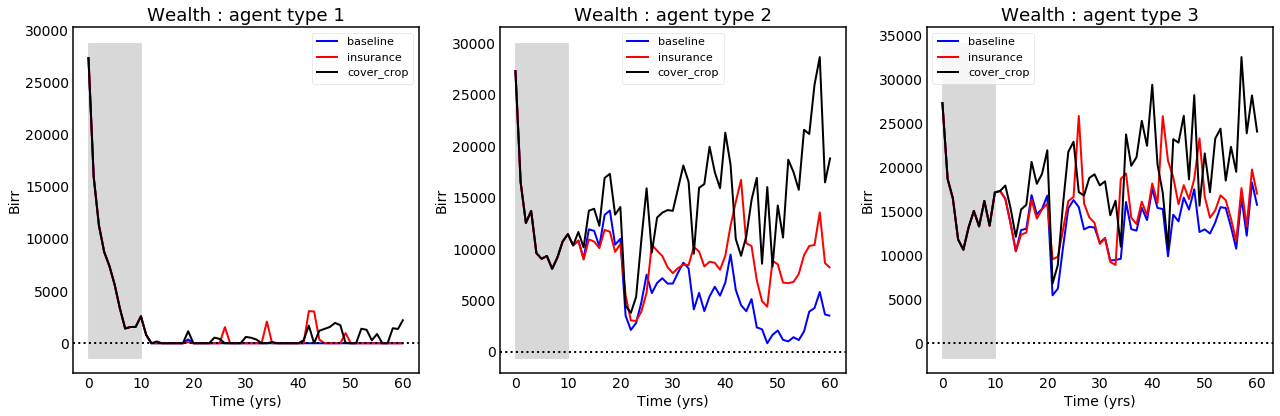

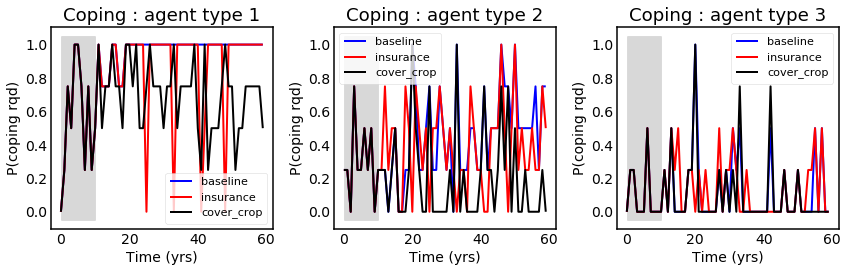

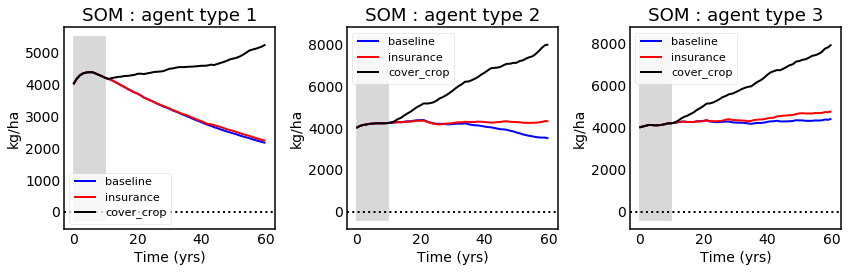

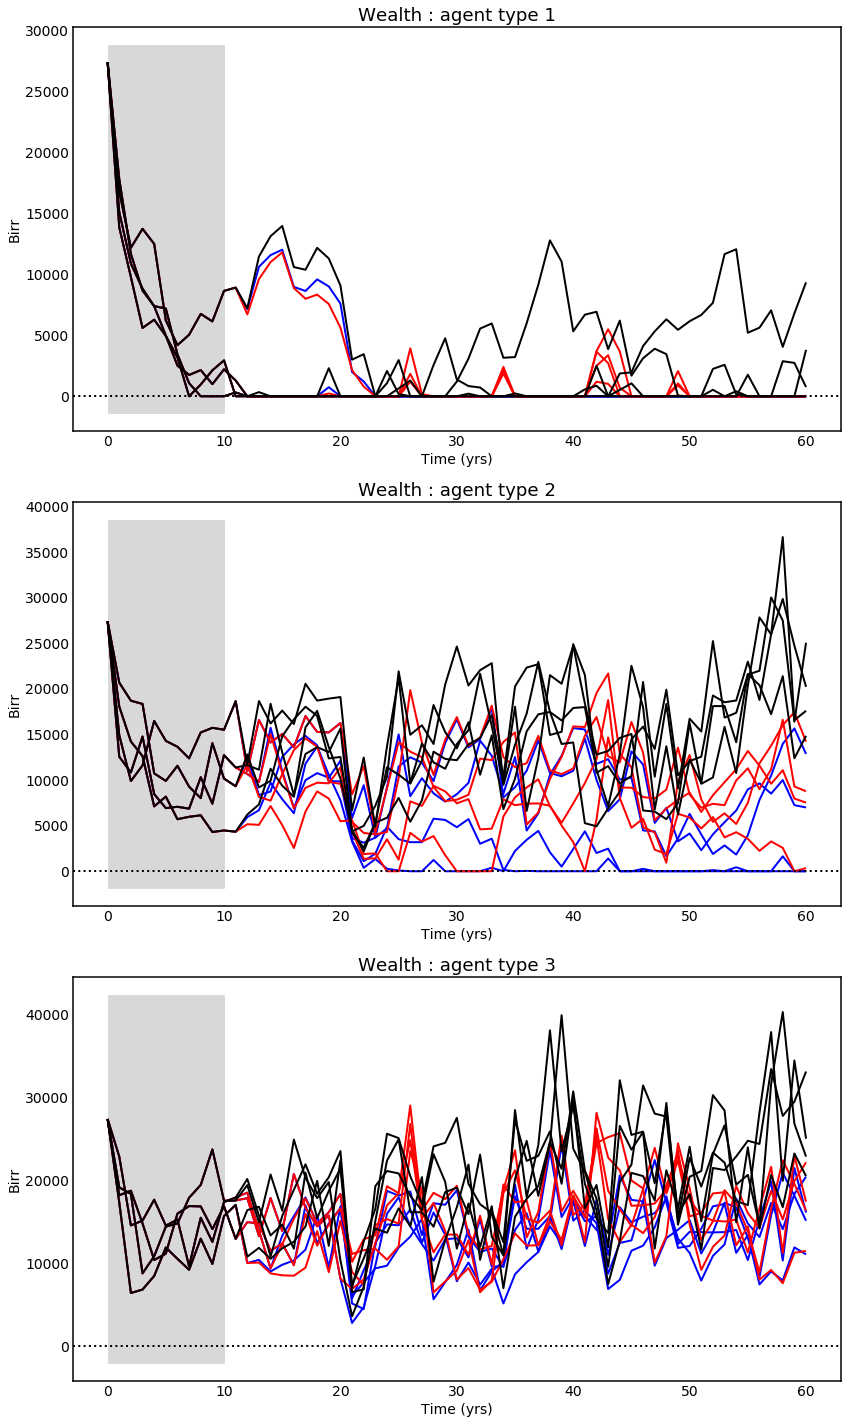

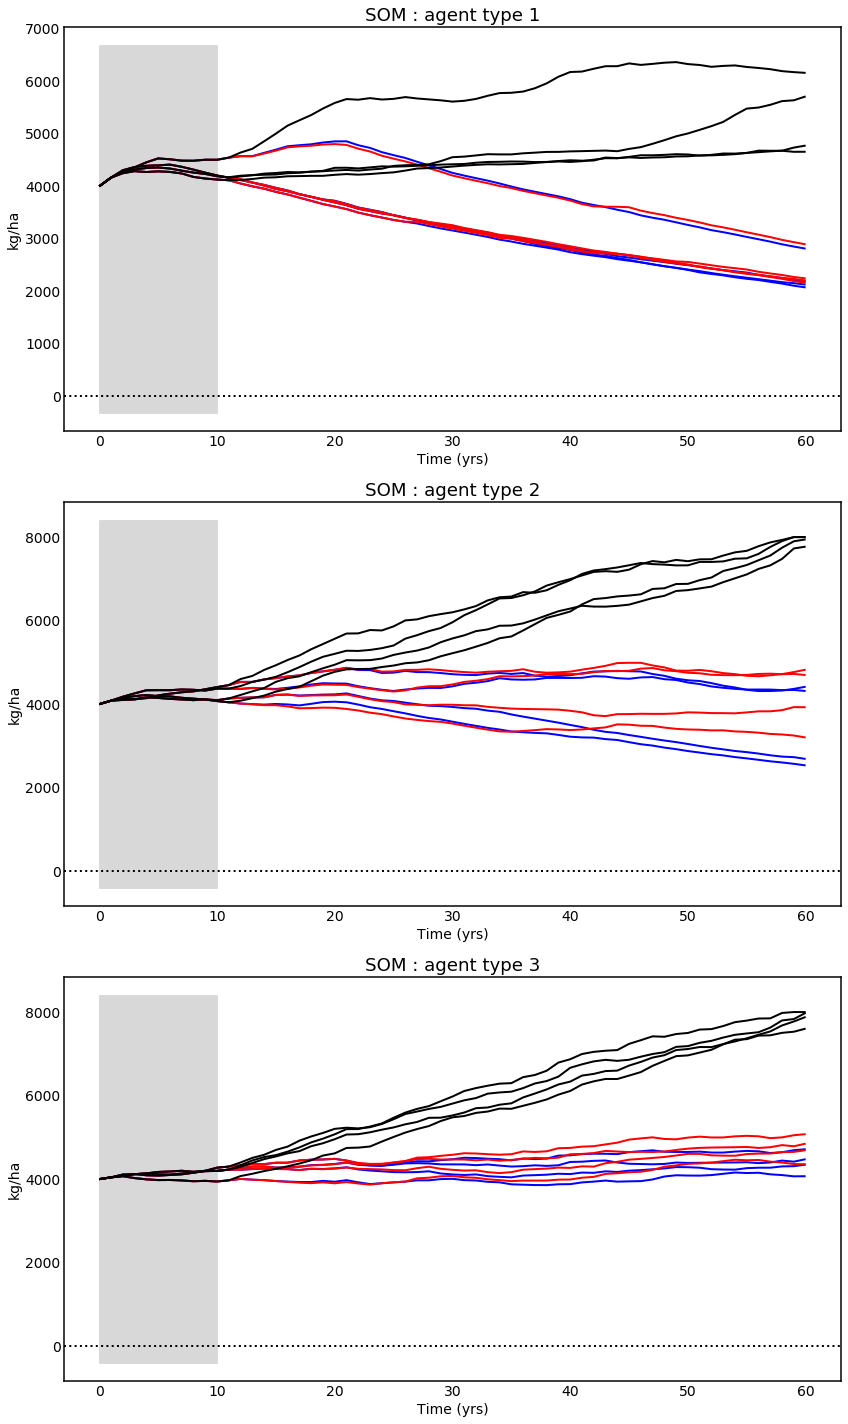

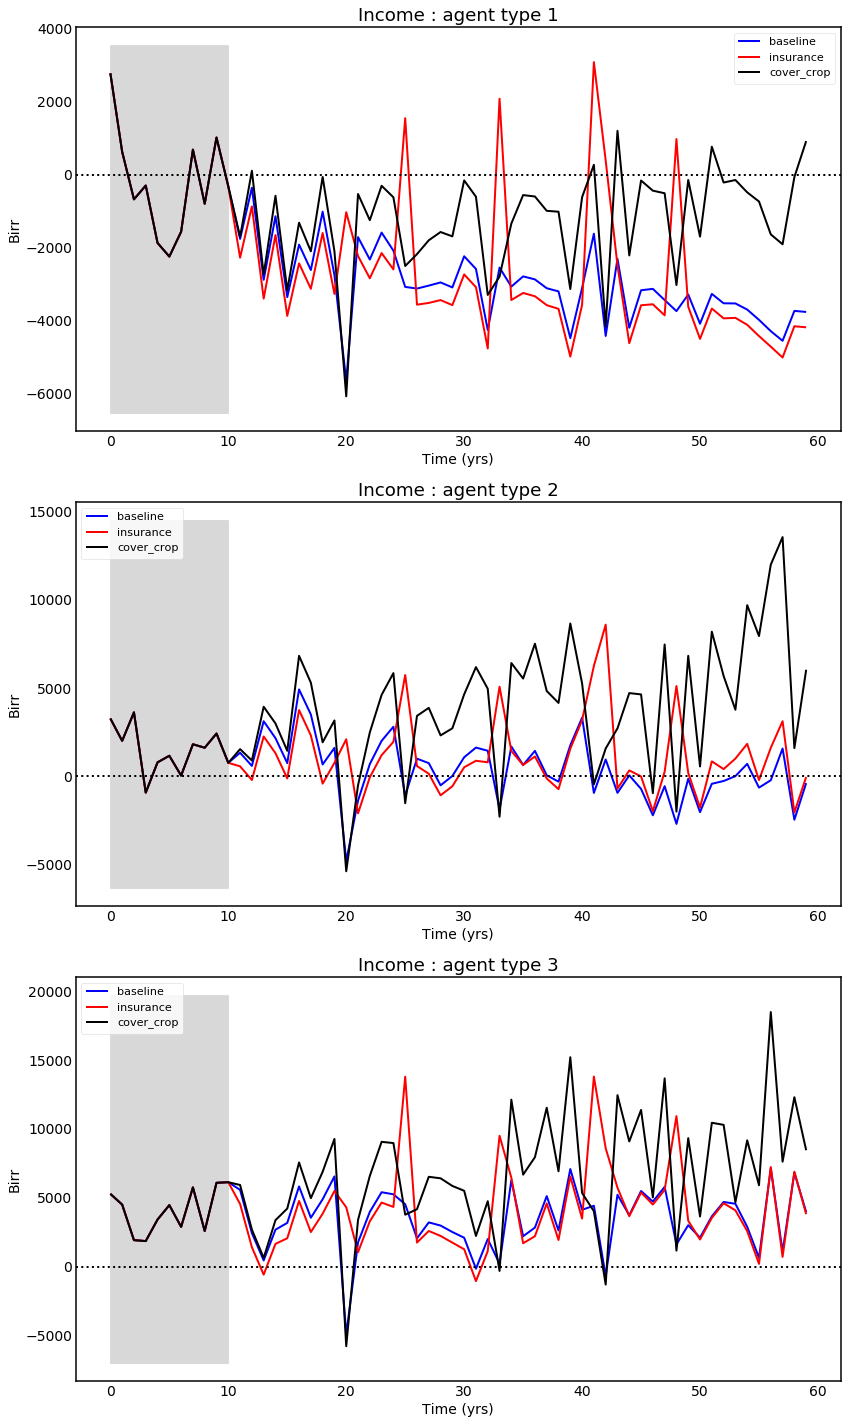

In [61]:
imp.reload(plt_sc)
plt_sc.main(mods, save=False)